In [58]:
import pandas as pd
import pyodbc
from claudia import ks,gini
#from psi import psi
from woe5 import woe
import numpy as np

In [7]:
import numpy as np
class woes(woe):
    def __init__(self,bins=None,nbreaks=10,stat=None,name=None,seed=123):
        super().__init__(bins,nbreaks,stat,name)
        self.seed=seed
        self.results=None
        self.frames=[]
    
    

    def re_fit(self,nbreaks=10):
        
        x=self.df['X']
        y=self.df['Y']

        #'''Fitting Information'''
        #if not isinstance(x, pd.Series):
        #    x = pd.Series(x.compute())
        #if not isinstance(y, pd.Series):
        #    y = pd.Series(y.compute())
            
        #self.name=x.name
                           
        #df = pd.DataFrame({"X": x, "Y": y, 'order': np.arange(x.size)})
        df=self.df
        
        #if self.bins is None:
        breaks=pd.qcut(df["X"],nbreaks,duplicates='drop',retbins=True)[1]
        breaks=breaks[1:-1]
        bins=[]
        bins.append(-float('Inf'))
        for i in breaks:
            bins.append(i)
        bins.append(float('Inf'))
        self.bins=bins
           
        q = pd.cut(df['X'], bins=self.bins,
                   labels=np.arange(len(self.bins)-1).astype(int))
        
        df['labels']=q.astype(str)
       # q = pd.cut(df['X'], bins=self.bins)
       # df['range']=q.astype(str)
        col_names = {'count_nonzero': 'bad', 'size': 'obs'}
        #self.stat = df.groupby(["labels","range"])['Y'].agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names).copy()  
        self.stat = df.groupby(["labels"])['Y'].agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names).copy()
        self.stat['bad_perc']=self.stat['bad']/sum(self.stat['bad'])
        self.stat['good']=self.stat['obs']-self.stat['bad']
        self.stat['good_perc']=self.stat['good']/sum(self.stat['good'])
        self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
        self.stat['iv']= (self.stat['good_perc']-self.stat['bad_perc'])*self.stat['woe']               
        self.stat['per']= self.stat['obs']/sum(self.stat['obs'])
        self.stat['index'] = self.stat.index
        NA=self.stat[self.stat['index'] =='nan']
        self.stat=self.stat[self.stat['index'] !='nan']
        self.stat['index'] = pd.to_numeric(self.stat['index'])
        self.stat=self.stat.sort_values('index')
        self.stat['breaks']=self.bins[1:len(self.bins)]
        self.stat=pd.concat([self.stat,NA],sort=True)
        self.iv=sum(self.stat['iv']) 
        #self.df=df
        self.per_NA=sum(df['X'].isnull())/len(df)
        self.stat['z']=self.name
    
    
    def auto_optimize(self,number_nodes=6,deep=7,min_per=0.05,percentilizar=True):
        iv_check = 0
        
        depths=range(1,deep) #Hasta una profundidad de 6 
        nodes=range(2,number_nodes) 
        
        if percentilizar:
            for k in range(2,11):
                self.re_fit(nbreaks=k)
                if self._checkMonotonic() and (self.iv> iv_check)  :
                    bins=self.bins
                    stat=self.stat 
                    name=self.name
                    iv_check = self.iv
                    iv=self.iv
                else:
                    pass  
        
        for j in depths:
            for i in nodes:
                self.optimize(depth=j,samples=round(len(self.df['X'])*0.05),seed=self.seed,max_nodes=i)
                if  self._checkMonotonic() and (self.iv> iv_check)  :
                    bins=self.bins
                    stat=self.stat 
                    name=self.name
                    iv_check = self.iv
                    iv=self.iv
                else:
                    pass
        
        self.bins=bins
        self.stat=stat
        self.name=name
        self.iv= iv
    
    def auto_merge(self,bin1,bin2):
        ''' Parameters
        ----------
        bin1,bin2 : ndarray
            Rows that we want to combine

        Returns
        -------
        Update the table of the object
   
        '''
        table=self.merge(self.stat,bin1,bin2)
        self.stat=table
        
    def auto_deploy(self,df):
        df['WOE_'+str(self.name)]=z.deploy(df)
        
        
    
    def fit_all(self,df,y,deploy=False,train=None,test=None,base=None,number_nodes=6,deep=7,min_per=0.05):
        def ivss(x):
            try:
                z=woes()
                z.fit(x,y)
                z.auto_optimize(number_nodes=number_nodes,deep=deep,min_per=min_per)
                self.frames.append(z.stat)
                iv=z.iv
                if deploy:
                    train[str(z.name+'_binned')]=z.deploy(train)
                    test[str(z.name+'_binned')]=z.deploy(test) 
                    base[str(z.name+'_binned')]=z.deploy(base) 
            except:
                iv=None
            return iv
        
        results=df.apply(lambda x: ivss(x),axis=0)
        self.results=results
        
    def deploy_cate(self,df):
        enci={}
        for i in range(len(self.stat)):
            enci[str(self.stat.iloc[i,5])]=self.stat.iloc[i,10] 
        df[str(self.name)+'_binned']=df[str(self.name)].copy()
        cleanup_nums = {str(self.name)+'_binned': enci}
        df.replace(cleanup_nums, inplace=True)
    
    def fit_categorical(self,x,y):
        if not isinstance(x, pd.Series):
            x = pd.Series(x.compute())
        if not isinstance(y, pd.Series):
            y = pd.Series(y.compute())
            
        self.name=x.name
                           
        df = pd.DataFrame({"X": x, "Y": y, 'order': np.arange(x.size)})
        col_names = {'count_nonzero': 'bad', 'size': 'obs'}
        self.stat = df.groupby(["X"])['Y'].agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names).copy()
        self.stat['bad_perc']=self.stat['bad']/sum(self.stat['bad'])
        self.stat['good']=self.stat['obs']-self.stat['bad']
        self.stat['good_perc']=self.stat['good']/sum(self.stat['good'])
        self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
        self.stat['iv']= (self.stat['good_perc']-self.stat['bad_perc'])*self.stat['woe']               
        self.stat['per']= self.stat['obs']/sum(self.stat['obs'])
        self.stat['index'] = self.stat.index

        self.iv=sum(self.stat['iv']) 
        self.df=df
        self.per_NA=sum(df['X'].isnull())/len(df)
        
        self.stat['breaks']=self.stat['index']
        self.stat['z']='vec_final'
        self.stat=self.stat[['bad', 'bad_perc', 'breaks','good' ,'good_perc','index','iv','mean','obs','per','woe','z']]
    

    @staticmethod
    def merge(obj,bin1,bin2):
            binn =  pd.DataFrame({'bad': [obj.iloc[bin2,0]+obj.iloc[bin1,0]],
                    'bad_perc' :0,
                    'breaks':obj.iloc[bin1,2],
                     'good': [obj.iloc[bin2,3]+obj.iloc[bin1,3]],
                    'good_perc' :0,
                    'index':obj.iloc[bin1,5],
                    'iv':0,
                    'mean':0,
                    'obs':0,
                    'per':0,
                    'woe':0,
                    'z':obj.iloc[bin1,11]
                    })
            for i in list(range(12)):
                obj.iloc[bin1,i]=binn.iloc[0,i]
            obj.iloc[bin2,0:10]=0
            obj['obs']=obj['good']+obj['bad']
            obj['mean']=obj['bad']/obj['obs']
            obj['good_perc']=obj['good']/sum(obj['good'])
            obj['bad_perc']=obj['bad']/sum(obj['bad'])
            obj['woe'][bin1] = np.log(obj['good_perc'][bin1]/obj['bad_perc'][bin1])
            obj['iv']= (obj['good_perc']-obj['bad_perc'])*obj['woe']               
            obj['per']= obj['obs']/sum(obj['obs'])
            obj['woe'][bin2]=obj['woe'][bin1]
            return obj
        


# Extracción de data

Filtros: 
Experiencia en el sistema financiero de 6 meses,
Experiencia en Compartamos Financiera de 6 meses,
Atrasos internos menores a 8 días

In [8]:
query=' select  * \
from bdrie.dbo.valincom  \
where   n_rcc >= 6  and flag_ini = 0  and nexpcli >= 6     --and natrmax_flag = 1 '
    
sql_con = pyodbc.connect('driver={SQL Server};SERVER=OF00SRVBDH;Trusted_Connection=True;DATABASE=MIS1')
comp = pd.read_sql(query, sql_con)


In [9]:
comp.flag_final.value_counts()

0    411526
2    178605
1     94430
Name: flag_final, dtype: int64

# Train Test Split

In [10]:
compf=comp[comp['flag_final']!=2]

In [12]:
compf.flag_final.value_counts()

0    411526
1     94430
Name: flag_final, dtype: int64

In [16]:
94430/505956

0.1866367826451312

In [13]:
y_comp=compf['flag_final']
X_comp=compf.drop(['flag_final'],axis = 1)

In [14]:
X_comp.shape

(505956, 27)

In [15]:
from sklearn.model_selection import train_test_split
X_trainc, X_testc, y_trainc, y_testc = train_test_split(X_comp, y_comp, test_size=0.33, random_state=123)

In [83]:
#y_trainc=pd.DataFrame(y_trainc)

# Auditoria de datos

In [16]:
auditoria=pd.DataFrame()
names=[]
per_na=[]
minimo =[]
maximo = []
promedio=[]
for column in X_trainc.columns:
    try:
        names.append(column)
        per_na.append(sum(X_trainc[column].isna())/len(X_trainc))
        #minimo.append(X_trainc[column].min())
        #maximo.append(X_trainc[column].max())
        #promedio.append(X_trainc[column].mean())
    except:
        pass
    
auditoria['names']=names
auditoria['per_na']=per_na
#auditoria['minimo']=minimo
#auditoria['maximo']=maximo
#auditoria['promedio']=promedio

auditoria


,names,per_na
0,ccalext,0.000000
1,ccodcli,0.000000
2,Z,0.000000
3,nexpcli,0.000000
4,betasvivienda,0.000000
5,edad,0.000000
6,nromesesatrasos8,0.000000
7,mesesdesdeelmaximo,0.000000
8,nroentidadesacreedoras,0.000000
9,atrasomaximo6meses,0.000000


In [17]:
X_trainc.describe()

,Z,nexpcli,edad,nromesesatrasos8,mesesdesdeelmaximo,nroentidadesacreedoras,atrasomaximo6meses,indcomportamiento,atr12meses,PRE_1,flag,n_rcc,atraso12,atraso0,diasAtr12,flag_ini
count,338990.000000,338990.000000,338990.000000,338990.000000,338990.000000,338990.000000,338990.000000,338990.000000,337576.000000,338990.000000,338990.000000,338990.0,338990.000000,338990.000000,338990.000000,338990.0
mean,-2.534379,39.593074,43.359860,0.200274,6.234051,2.077899,3.073504,3.395902,40.040133,0.104134,0.207165,6.0,21.010289,0.279079,42.066235,0.0
std,1.082750,32.707758,12.800821,0.815440,3.720346,1.048975,6.025764,9.396080,102.935553,0.122364,0.466269,0.0,59.545339,2.684782,102.238337,0.0
min,-7.008000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000904,0.000000,6.0,-241.000000,-27.000000,0.000000,0.0
25%,-3.181000,15.000000,33.000000,0.000000,3.000000,1.000000,0.000000,2.000000,0.000000,0.039887,0.000000,6.0,1.000000,0.000000,1.000000,0.0
50%,-2.574000,28.000000,43.000000,0.000000,6.000000,2.000000,1.000000,2.000000,0.000000,0.070831,0.000000,6.0,3.000000,0.000000,3.000000,0.0
75%,-1.981000,56.000000,53.000000,0.000000,9.000000,3.000000,4.000000,2.000000,0.000000,0.121212,0.000000,6.0,6.000000,1.000000,7.000000,0.0
max,10.763000,241.000000,86.000000,6.000000,12.000000,10.000000,283.000000,97.000000,5630.000000,0.999979,2.000000,6.0,598.000000,8.000000,5630.000000,0.0


# IVs

In [38]:
import numpy as np

In [18]:
%%time
q=woes()
q.fit_all(X_trainc, y_trainc,deploy=True,train=X_trainc,test=X_testc,base=comp)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in log
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in true_divide
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in true_divide
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_per

C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in true_divide
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\Users\jcondori\woe5.py:58: RuntimeWarning: divide by zero encountered in log
  self.stat['woe'] = np.log(self.stat['good_perc'].values/self.stat['bad_perc'].values)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#

Wall time: 7min 4s


In [24]:
frames=q.frames
ivs=q.results

In [25]:
ivs.dropna().sort_values(ascending = False)

diasAtr12                      inf
atraso12                       inf
flag                           inf
atr12meses                     inf
PRE_1                     1.087486
Z                         1.087410
indcomportamiento         0.581434
nromesesatrasos8          0.505004
atrasomaximo6meses        0.492277
atraso0                   0.358847
nroentidadesacreedoras    0.336796
mesesdesdeelmaximo        0.083517
nexpcli                   0.081332
edad                      0.050250
dtype: float64

In [32]:
ivs=pd.DataFrame(ivs)
ivs=ivs.reset_index()
ivs.columns=['Names','IV']

names=[]
for frame in frames:
    names.append(frame.z.unique()[0])
names=pd.DataFrame(names)
names.reset_index(inplace=True)
names.columns=['ind','name']

def check(variable):
    print(frames[int(names[names['name']==variable]['ind'])])
    print(ivs[ivs['Names']==variable])
    
def get_var(variable):
    return frames[int(names[names['name']==variable]['ind'])]

In [34]:
X_trainc.columns

Index(['ccalext', 'ccodcli', 'Z', 'nexpcli', 'betasvivienda', 'edad',
       'nromesesatrasos8', 'mesesdesdeelmaximo', 'nroentidadesacreedoras',
       'atrasomaximo6meses', 'indcomportamiento', 'dfecrep', 'cconviv',
       'atr12meses', 'PRE_1', 'ccalcomp', 'flag', 'ccodsbs', 'natrmax',
       'natrmax_flag', 'n_rcc', 'atraso12', 'atraso0', 'diasAtr12', 'flag_ini',
       'rango0', 'rango12', 'Z_binned', 'nexpcli_binned', 'edad_binned',
       'nromesesatrasos8_binned', 'mesesdesdeelmaximo_binned',
       'nroentidadesacreedoras_binned', 'atrasomaximo6meses_binned',
       'indcomportamiento_binned', 'atr12meses_binned', 'PRE_1_binned',
       'flag_binned', 'atraso12_binned', 'atraso0_binned', 'diasAtr12_binned'],
      dtype='object')

In [256]:
check('atrasomaximo6meses')

          bad  bad_perc    breaks    good  good_perc index        iv  \
labels                                                                 
0       11182  0.176261  1.000000  108640   0.394266     0  0.175507   
1       21156  0.333480  2.000000   94657   0.343520     1  0.000298   
2       18469  0.291125  3.000000   49960   0.181310     2  0.052003   
3        9555  0.150615  4.000000   18077   0.065603     3  0.070653   
4        3078  0.048518       inf    4216   0.015300     4  0.038336   

            mean     obs       per       woe                       z  
labels                                                                
0       0.093322  119822  0.353468  0.805060  nroentidadesacreedoras  
1       0.182674  115813  0.341641  0.029662  nroentidadesacreedoras  
2       0.269900   68429  0.201861 -0.473545  nroentidadesacreedoras  
3       0.345795   27632  0.081513 -0.831099  nroentidadesacreedoras  
4       0.421991    7294  0.021517 -1.154068  nroentidadesacreedoras 

In [309]:
get_var('indcomportamiento')

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0,51119,0.805785,2.000000,272757,0.989864,0,0.037874,0.157835,323876,0.955415,0.205751,indcomportamiento
1,12321,0.194215,inf,2793,0.010136,1,0.543560,0.815204,15114,0.044585,-2.952863,indcomportamiento


# Analizando número de meses con atrasos > 8 

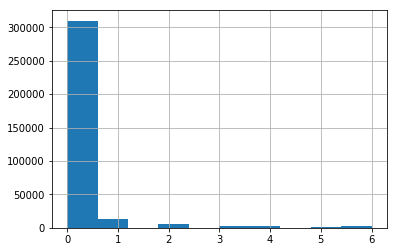

In [46]:
X_trainc['nromesesatrasos8'].hist()

In [48]:
X_trainc['nromesesatrasos8'].value_counts()/len(X_trainc)

0    0.913826
1    0.040942
2    0.016552
3    0.009472
6    0.008245
4    0.006469
5    0.004493
Name: nromesesatrasos8, dtype: float64

In [42]:
rr=woes()
rr.fit(X_trainc['nromesesatrasos8'],y_trainc)
rr.optimize()
rr.stat

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0,45898,0.723487,0.500000,263880,0.957648,0,0.065659,0.148164,309778,0.913826,0.280398,nromesesatrasos8
1,9720,0.153216,2.500000,9770,0.035456,1,0.172346,0.498717,19490,0.057494,-1.463544,nromesesatrasos8
2,7822,0.123298,inf,1900,0.006895,2,0.335676,0.804567,9722,0.028679,-2.883761,nromesesatrasos8


In [43]:
rr.iv

0.5736807882610772

Deploy

In [ ]:
#train[str(rr.name+'_binned')]=rr.deploy(X_trainc)
#test[str(rr.name+'_binned')]=rr.deploy(X_testc) 
#base[str(rr.name+'_binned')]=rr.deploy(comp) 

# Analizando Número de Entidades Acreedoras

In [257]:
rr=woes()
rr.fit(X_trainc['nroentidadesacreedoras'],y_trainc)
rr.optimize()
rr.stat

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
labels,,,,,,,,,,,,
0,11182,0.176261,1.500000,108640,0.394266,0,0.175507,0.093322,119822,0.353468,0.805060,nroentidadesacreedoras
1,21156,0.333480,2.500000,94657,0.343520,1,0.000298,0.182674,115813,0.341641,0.029662,nroentidadesacreedoras
2,18469,0.291125,3.500000,49960,0.181310,2,0.052003,0.269900,68429,0.201861,-0.473545,nroentidadesacreedoras
3,12633,0.199133,inf,22293,0.080904,3,0.106491,0.361708,34926,0.103030,-0.900714,nroentidadesacreedoras


In [260]:
rr.iv

0.3342983092173798

In [262]:
X_trainc[str(rr.name+'_binned')]=rr.deploy(X_trainc)
X_testc[str(rr.name+'_binned')]=rr.deploy(X_testc) 
comp[str(rr.name+'_binned')]=rr.deploy(comp) 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [298]:
comp.nroentidadesacreedoras_binned.unique()

array([-0.90071423,  0.02966176, -0.47354549,  0.8050598 ])

# Categoricas

1       	PROPIA NO INSCRITA                                                    
6       	PROPIA INSCRITA                                                       
2       	FAMILIAR                                                              
3       	ALQUILER      ->  S                                                      
4       	ANTICRESIS    ->   S                                                     
5       	ALOJADO       ->    S                                                    
0       	NO DEFINIDO   ->  S                                                      

In [78]:
m=woes()
m.fit_categorical(X_trainc['cconviv'],y_trainc)
m.stat

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
X,,,,,,,,,,,,
,74,0.001166,,254,0.000922,,0.000058,0.225610,328,0.000968,-0.235405,vec_final
0,330,0.005202,0,1011,0.003669,0,0.000535,0.246085,1341,0.003956,-0.349072,vec_final
1,18263,0.287878,1,95064,0.344997,1,0.010338,0.161153,113327,0.334308,0.180999,vec_final
2,32309,0.509284,2,121752,0.441851,2,0.009578,0.209716,154061,0.454471,-0.142034,vec_final
3,5856,0.092308,3,17555,0.063709,3,0.010604,0.250139,23411,0.069061,-0.370802,vec_final
4,28,0.000441,4,93,0.000338,4,0.000028,0.231405,121,0.000357,-0.268280,vec_final
5,1868,0.029445,5,6333,0.022983,5,0.001601,0.227777,8201,0.024192,-0.247769,vec_final
6,4712,0.074275,6,33488,0.121531,6,0.023269,0.123351,38200,0.112688,0.492400,vec_final


In [198]:
m.auto_merge(4,1)
m.auto_merge(4,5)
m.auto_merge(4,6)
m.auto_merge(4,0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [199]:
m.stat

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.338761,vec_final
0,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.339758,vec_final
1,18263,0.287878,1,95064,0.344997,1,0.010338,0.161153,113327,0.334308,0.180999,vec_final
2,32309,0.509284,2,121752,0.441851,2,0.009578,0.209716,154061,0.454471,-0.142034,vec_final
3,8156,0.128562,3,25246,0.091620,3,0.012515,0.244177,33402,0.098534,-0.338761,vec_final
4,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.339758,vec_final
5,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.339758,vec_final
6,4712,0.074275,6,33488,0.121531,6,0.023269,0.123351,38200,0.112688,0.492400,vec_final


In [200]:
m.stat.woe[0]=-0.338761
m.stat.woe[1]=-0.338761
m.stat.woe[5]=-0.338761
m.stat.woe[6]=-0.338761
m.stat.woe[4]=-0.338761

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anac

In [201]:
m.stat

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.338761,vec_final
0,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.338761,vec_final
1,18263,0.287878,1,95064,0.344997,1,0.010338,0.161153,113327,0.334308,0.180999,vec_final
2,32309,0.509284,2,121752,0.441851,2,0.009578,0.209716,154061,0.454471,-0.142034,vec_final
3,8156,0.128562,3,25246,0.091620,3,0.012515,0.244177,33402,0.098534,-0.338761,vec_final
4,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.338761,vec_final
5,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.338761,vec_final
6,4712,0.074275,6,33488,0.121531,6,0.023269,0.123351,38200,0.112688,0.492400,vec_final


In [205]:
m.stat.breaks=[' ', '0', '1', '2', '3', '4', '5', '6']
m.stat['index']=[' ', '0', '1', '2', '3', '4', '5', '6']

In [228]:
m.stat

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,z
,0,0.000000,,0,0.000000,,-0.000000,NaN,0,0.000000,-0.338761,vec_final
0,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.338761,vec_final
1,18263,0.287878,1,95064,0.344997,1,0.010338,0.161153,113327,0.334308,0.180999,vec_final
2,32309,0.509284,2,121752,0.441851,2,0.009578,0.209716,154061,0.454471,-0.142034,vec_final
3,8156,0.128562,3,25246,0.091620,3,0.012515,0.244177,33402,0.098534,-0.338761,vec_final
4,0,0.000000,4,0,0.000000,4,-0.000000,NaN,0,0.000000,-0.338761,vec_final
5,0,0.000000,5,0,0.000000,5,-0.000000,NaN,0,0.000000,-0.338761,vec_final
6,4712,0.074275,6,33488,0.121531,6,0.023269,0.123351,38200,0.112688,0.492400,vec_final


In [206]:
m.iv

0.05601153596442041

In [207]:
m.stat.woe.unique()

array([-0.338761  ,  0.18099867, -0.14203416,  0.4924002 ])

In [208]:
m.deploy_cate(X_testc)
m.deploy_cate(X_trainc)
m.deploy_cate(comp)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


In [209]:
X_trainc.cconviv_binned.unique()

array([ 0.18099867, -0.14203416,  0.4924002 , -0.338761  ])

In [299]:
comp.cconviv_binned.unique()

array([ 0.18099867, -0.14203416,  0.4924002 , -0.338761  ])

# Filtrando Columnas no necesarias

In [151]:
ivs_2=ivs[(ivs['IV']>=0.02) & (ivs['IV']!=float('Inf'))]
ivs_2['Names']=ivs_2['Names']+str('_binned')
filter_cols=list(ivs_2['Names'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [152]:
filter_cols

['Z_binned',
 'nexpcli_binned',
 'edad_binned',
 'nromesesatrasos8_binned',
 'mesesdesdeelmaximo_binned',
 'nroentidadesacreedoras_binned',
 'atrasomaximo6meses_binned',
 'indcomportamiento_binned',
 'PRE_1_binned',
 'atraso0_binned']

In [263]:
filter_cols = ['nexpcli_binned',
 'edad_binned',
 'nromesesatrasos8_binned',
 'mesesdesdeelmaximo_binned',
 'nroentidadesacreedoras_binned',
 'atrasomaximo6meses_binned','cconviv_binned']

In [154]:
X_trainc.columns

Index(['ccalext', 'ccodcli', 'Z', 'nexpcli', 'betasvivienda', 'edad',
       'nromesesatrasos8', 'mesesdesdeelmaximo', 'nroentidadesacreedoras',
       'atrasomaximo6meses', 'indcomportamiento', 'dfecrep', 'cconviv',
       'atr12meses', 'PRE_1', 'ccalcomp', 'flag', 'ccodsbs', 'natrmax',
       'natrmax_flag', 'n_rcc', 'atraso12', 'atraso0', 'diasAtr12', 'flag_ini',
       'rango0', 'rango12', 'Z_binned', 'nexpcli_binned', 'edad_binned',
       'nromesesatrasos8_binned', 'mesesdesdeelmaximo_binned',
       'nroentidadesacreedoras_binned', 'atrasomaximo6meses_binned',
       'indcomportamiento_binned', 'atr12meses_binned', 'PRE_1_binned',
       'flag_binned', 'atraso12_binned', 'atraso0_binned', 'diasAtr12_binned',
       'cconviv_binned'],
      dtype='object')

In [168]:
#X_trainf=X_trainc[X_trainc['cconviv']!=' ']
#X_testf=X_testc[X_testc['cconviv']!=' ']

In [264]:
X_trainf.cconviv_binned.unique()

array([ 0.18099867, -0.14203416,  0.4924002 , -0.338761  ])

In [265]:
X_trainf=X_trainc[filter_cols]
X_testf=X_testc[filter_cols]

In [266]:
X_trainf["cconviv_binned"] = pd.to_numeric(X_trainf["cconviv_binned"])
X_testf["cconviv_binned"] = pd.to_numeric(X_testf["cconviv_binned"])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Modelo

In [36]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [269]:
X_trainf=sm.add_constant(X_trainf)
X_testf=sm.add_constant(X_testf)

In [270]:
print(y_trainc.shape)
print(X_trainf.shape)

(338990,)
(338990, 8)


In [46]:
X_trainf.head()

,const,nexpcli_binned,edad_binned,nromesesatrasos8_binned,mesesdesdeelmaximo_binned,nroentidadesacreedoras_binned,atrasomaximo6meses_binned,cconviv_binned
593888,1.0,-0.205873,0.240042,0.280398,-0.027798,0.029662,0.736922,0.180999
171175,1.0,-0.006878,0.092717,0.280398,-0.433681,-0.473545,0.332210,0.180999
357691,1.0,0.649883,0.092717,0.280398,-0.027798,0.805060,0.332210,-0.142034
355962,1.0,-0.205873,0.240042,0.280398,-0.027798,0.029662,0.736922,-0.142034
140953,1.0,-0.205873,0.240042,0.280398,0.110311,0.029662,0.736922,0.180999


In [271]:
model=sm.Logit(1-y_trainc, X_trainf.astype(float)).fit()
#est = sm.OLS(y.ast 

Optimization terminated successfully.
         Current function value: 0.384029
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             flag_final   No. Observations:               338990
Model:                          Logit   Df Residuals:                   338982
Method:                           MLE   Df Model:                            7
Date:                Mon, 18 Nov 2019   Pseudo R-squ.:                  0.2034
Time:                        18:05:12   Log-Likelihood:            -1.3018e+05
converged:                       True   LL-Null:                   -1.6341e+05
                                        LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.4742      0.005    285.926      0.000       1.464       1.484
nexpcli_binned                    1.0120      0.019     52.192      0.000       0.974       1.050
edad_binned                       0.5729      0.023     24.431      0.000       0.527       0.619
nromesesatrasos8_binned           0.8225      0.007    118.804      0.000       0.809       0.836
mesesdesdeelmaximo_binned         1.2546      0.018     68.734      0.000       1.219       1.290
nroentidadesacreedoras_binned     0.8915      0.009     98.795      0.000       0.874       0.909
atrasomaximo6meses_binned         0.8797      0.007    123.388      0.000       0.866       0.894
cconviv_binned                    0.6149      0.023     27.274      0.000       0.571       0.659
=================================================================================================
"""

In [48]:
model=sm.Logit(1-y_trainc, X_trainf.astype(float)).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.384029
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             flag_final   No. Observations:               338990
Model:                          Logit   Df Residuals:                   338982
Method:                           MLE   Df Model:                            7
Date:                Tue, 26 Nov 2019   Pseudo R-squ.:                  0.2034
Time:                        15:58:05   Log-Likelihood:            -1.3018e+05
converged:                       True   LL-Null:                   -1.6341e+05
                                        LLR p-value:                     0.000
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                             1.4742      0.005    285.926      0.000       1.464       1.484
nexpcli_binned                    1.0120      0.019     52.192      0.000       0.974       1.050
edad_binned                       0.5729      0.023     24.431      0.000       0.527       0.619
nromesesatrasos8_binned           0.8225      0.007    118.804      0.000       0.809       0.836
mesesdesdeelmaximo_binned         1.2546      0.018     68.734      0.000       1.219       1.290
nroentidadesacreedoras_binned     0.8915      0.009     98.795      0.000       0.874       0.909
atrasomaximo6meses_binned         0.8797      0.007    123.388      0.000       0.866       0.894
cconviv_binned                    0.6149      0.023     27.274      0.000       0.571       0.659
=================================================================================================
"""

Condición de vivienda en forma categórica

In [51]:
y_train_inv=1-y_trainc

In [54]:
mod = smf.logit(formula='flag_final ~ nexpcli_binned + edad_binned + nromesesatrasos8_binned+ mesesdesdeelmaximo_binned+ nroentidadesacreedoras_binned+ atrasomaximo6meses_binned + C(cconviv_binned)', data= pd.concat([X_trainf,y_train_inv],axis=1))
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.383980
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             flag_final   No. Observations:               338990
Model:                          Logit   Df Residuals:                   338980
Method:                           MLE   Df Model:                            9
Date:                Tue, 26 Nov 2019   Pseudo R-squ.:                  0.2035
Time:                        16:01:43   Log-Likelihood:            -1.3017e+05
converged:                       True   LL-Null:                   -1.6341e+05
                                        LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                     

In [301]:
check('indcomportamiento')

          bad  bad_perc    breaks    good  good_perc index        iv  \
labels                                                                 
0       51119  0.805785  2.000000  272757   0.989864     0  0.037874   
1       12321  0.194215       inf    2793   0.010136     1  0.543560   

            mean     obs       per       woe                  z  
labels                                                           
0       0.157835  323876  0.955415  0.205751  indcomportamiento  
1       0.815204   15114  0.044585 -2.952863  indcomportamiento  
                Names        IV
10  indcomportamiento  0.581434


In [55]:
mod = smf.logit(formula='flag_final ~ nexpcli_binned + edad_binned + nromesesatrasos8_binned+ mesesdesdeelmaximo_binned+ nroentidadesacreedoras_binned+ atrasomaximo6meses_binned + cconviv_binned + indcomportamiento_binned ', data= pd.concat([X_trainc,y_train_inv],axis=1))
res = mod.fit()
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.374137
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             flag_final   No. Observations:               338990
Model:                          Logit   Df Residuals:                   338981
Method:                           MLE   Df Model:                            8
Date:                Tue, 26 Nov 2019   Pseudo R-squ.:                  0.2239
Time:                        16:02:31   Log-Likelihood:            -1.2683e+05
converged:                       True   LL-Null:                   -1.6341e+05
                                        LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4655      0.005    278.974      0.

# Colinealidad

In [275]:
X_trainf.corr()

,const,nexpcli_binned,edad_binned,nromesesatrasos8_binned,mesesdesdeelmaximo_binned,nroentidadesacreedoras_binned,atrasomaximo6meses_binned,cconviv_binned
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nexpcli_binned,NaN,1.000000,0.268225,0.015303,0.113578,-0.044715,-0.022479,0.176599
edad_binned,NaN,0.268225,1.000000,0.015301,0.061722,-0.075371,0.075537,0.299317
nromesesatrasos8_binned,NaN,0.015303,0.015301,1.000000,-0.095514,0.152194,0.281078,0.021572
mesesdesdeelmaximo_binned,NaN,0.113578,0.061722,-0.095514,1.000000,0.154936,-0.056715,0.090449
nroentidadesacreedoras_binned,NaN,-0.044715,-0.075371,0.152194,0.154936,1.000000,0.075144,-0.021435
atrasomaximo6meses_binned,NaN,-0.022479,0.075537,0.281078,-0.056715,0.075144,1.000000,0.042347
cconviv_binned,NaN,0.176599,0.299317,0.021572,0.090449,-0.021435,0.042347,1.000000


In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

base_corr = X_trainf.values

vif = [variance_inflation_factor(base_corr, i) for i in range(base_corr.shape[1])]
#print(vif)

tabla_vif=pd.DataFrame()
tabla_vif['variables']=X_trainf.columns
tabla_vif['vif']=vif
tabla_vif

,variables,vif
0,const,1.091814
1,nexpcli_binned,1.104217
2,edad_binned,1.172877
3,nromesesatrasos8_binned,1.121794
4,mesesdesdeelmaximo_binned,1.065905
5,nroentidadesacreedoras_binned,1.068549
6,atrasomaximo6meses_binned,1.098495
7,cconviv_binned,1.116831


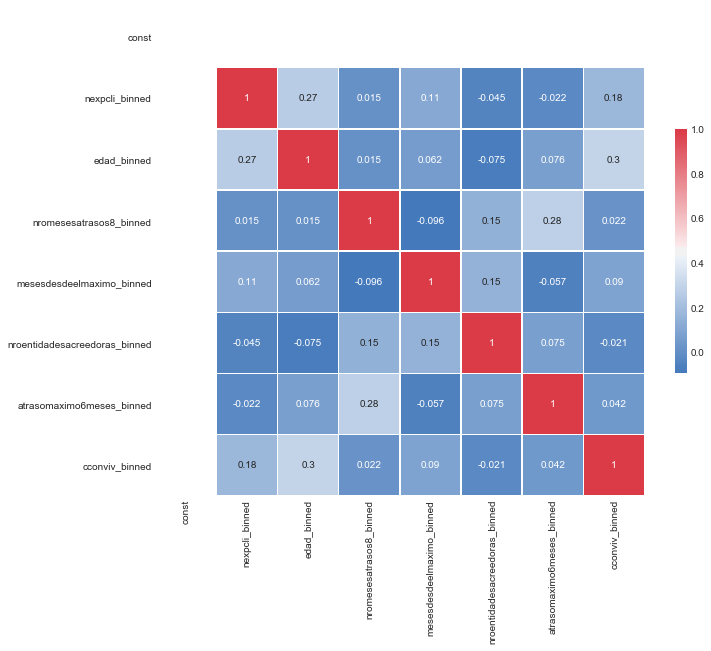

In [291]:
import seaborn as sns
import matplotlib.pyplot as plt

def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,annot=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


CorrMtx(X_trainf.corr(), dropDuplicates = False)

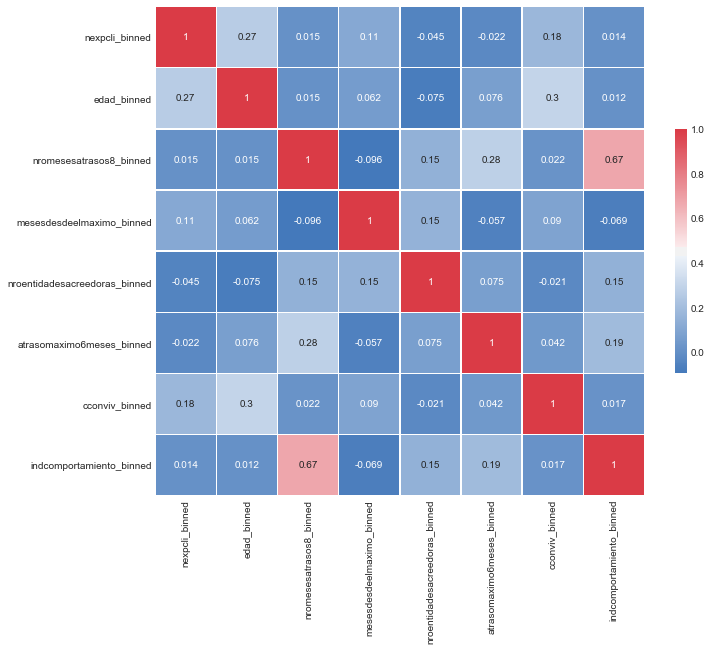

In [303]:
CorrMtx(X_trainc[['nexpcli_binned' ,'edad_binned' ,'nromesesatrasos8_binned', 'mesesdesdeelmaximo_binned', 'nroentidadesacreedoras_binned', 'atrasomaximo6meses_binned', 'cconviv_binned', 'indcomportamiento_binned']].corr(),dropDuplicates=False) 

# KS Gini

In [277]:
y_predict_test=model.predict(X_testf)
y_predict_train=model.predict(X_trainf)

Ks_2sampResult(statistic=0.4519571123716113, pvalue=0.0)


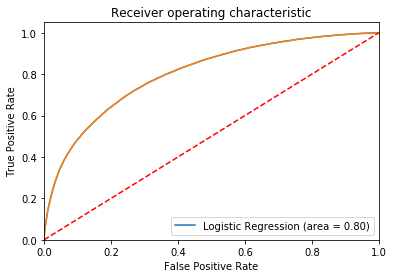

(0.8017998483429793, 0.6035996966859587)


In [278]:
print(ks(y_trainc,1-y_predict_train))
print(gini(y_trainc,1-y_predict_train,plot=True))

Ks_2sampResult(statistic=0.4535045770372362, pvalue=0.0)


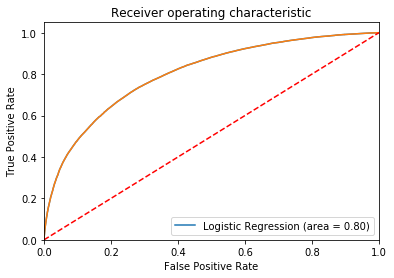

(0.8021105506622536, 0.6042211013245071)


In [279]:
print(ks(y_testc,1-y_predict_test))
print(gini(y_testc,1-y_predict_test,plot=True))

Con indicador de comportamiento

In [56]:
y_predict_test_cate=res.predict(X_testc)
y_predict_train_cate=res.predict(X_trainc)

Ks_2sampResult(statistic=0.4574029500325269, pvalue=0.0)


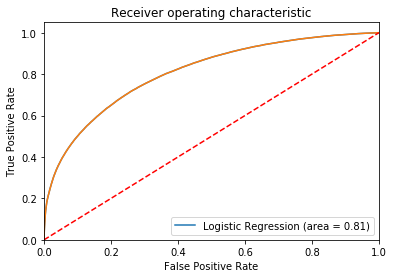

(0.8077479241619936, 0.6154958483239872)


In [59]:
print(ks(y_trainc,1-y_predict_train_cate))
print(gini(y_trainc,1-y_predict_train_cate,plot=True))

Ks_2sampResult(statistic=0.45765629815317904, pvalue=0.0)


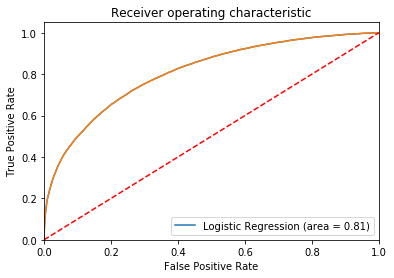

(0.8079142626207616, 0.6158285252415232)


In [60]:
print(ks(y_testc,1-y_predict_test_cate))
print(gini(y_testc,1-y_predict_test_cate,plot=True))

# Score Card

In [35]:
model.params

const                            1.474192
nexpcli_binned                   1.011953
edad_binned                      0.572929
nromesesatrasos8_binned          0.822494
mesesdesdeelmaximo_binned        1.254642
nroentidadesacreedoras_binned    0.891549
atrasomaximo6meses_binned        0.879729
cconviv_binned                   0.614913
dtype: float64

In [244]:
m.stat['z']='cconviv'

In [285]:
card=pd.concat([get_var('nexpcli'),\
get_var('edad'),\
get_var('nromesesatrasos8'),\
get_var('mesesdesdeelmaximo'),\
rr.stat, \
get_var('atrasomaximo6meses'),m.stat],axis=0)

In [286]:
import math
card2= card
results_summary = model.summary()
results_as_html = results_summary.tables[1].as_html()
results=pd.read_html(results_as_html, header=0, index_col=0)[0]
results=results.reset_index()
results['index'] = results['index'].map(lambda x: x.rstrip('binned'))
results['index'] = results['index'].map(lambda x: x.rstrip('_'))
#results['index'] = results['index'].map(lambda x: x[:4])
results=results.set_index('index')
card2=card2.set_index('z')
card2=card2.join(results['coef'])
card2.reset_index()

a_sumar=(model.params[0]*80/math.log(2))/(len(model.params)-1)
card2['puntaje']=round(card2['coef']*card2['woe']*100)
card2['puntaje_ajustado'] = round(card2['coef']*card2['woe']*80/math.log(2)+a_sumar)
#card_final=card2[(card2['mean'].notna()) & (card2['coef'].notna())]
card2

,bad,bad_perc,breaks,good,good_perc,index,iv,mean,obs,per,woe,coef,puntaje,puntaje_ajustado
atrasomaximo6meses,11313,0.178326,0.5,102673,0.372611,0,0.143173,0.099249,113986,0.336252,0.736922,0.8797,65.0,99.0
atrasomaximo6meses,14581,0.229839,2.5,88288,0.320406,1,0.030087,0.141743,102869,0.303457,0.332210,0.8797,29.0,58.0
atrasomaximo6meses,14856,0.234174,5.5,54364,0.197293,2,0.006321,0.214620,69220,0.204195,-0.171376,0.8797,-15.0,7.0
atrasomaximo6meses,13421,0.211554,10.5,21972,0.079739,3,0.128616,0.379199,35393,0.104407,-0.975726,0.8797,-86.0,-75.0
atrasomaximo6meses,9269,0.146107,inf,8253,0.029951,4,0.184080,0.528992,17522,0.051689,-1.584773,0.8797,-139.0,-137.0
cconviv,0,0.000000,,0,0.000000,,-0.000000,NaN,0,0.000000,-0.338761,0.6149,-21.0,0.0
cconviv,0,0.000000,0,0,0.000000,0,-0.000000,NaN,0,0.000000,-0.338761,0.6149,-21.0,0.0
cconviv,18263,0.287878,1,95064,0.344997,1,0.010338,0.161153,113327,0.334308,0.180999,0.6149,11.0,37.0
cconviv,32309,0.509284,2,121752,0.441851,2,0.009578,0.209716,154061,0.454471,-0.142034,0.6149,-9.0,14.0
cconviv,8156,0.128562,3,25246,0.091620,3,0.012515,0.244177,33402,0.098534,-0.338761,0.6149,-21.0,0.0


In [287]:
results

,coef,std err,z,P>|z|,[0.025,0.975]
index,,,,,,
const,1.4742,0.005,285.926,0.0,1.464,1.484
nexpcli,1.0120,0.019,52.192,0.0,0.974,1.050
edad,0.5729,0.023,24.431,0.0,0.527,0.619
nromesesatrasos8,0.8225,0.007,118.804,0.0,0.809,0.836
mesesdesdeelmaximo,1.2546,0.018,68.734,0.0,1.219,1.290
nroentidadesacreedoras,0.8915,0.009,98.795,0.0,0.874,0.909
atrasomaximo6meses,0.8797,0.007,123.388,0.0,0.866,0.894
cconviv,0.6149,0.023,27.274,0.0,0.571,0.659


# Puntaje 

In [249]:
import math
comp['puntaje']= (model.params[0]+ \
comp['nexpcli_binned']*model.params[1]+ \
comp['edad_binned']*model.params[2]+ \
comp['nromesesatrasos8_binned']*model.params[3]+ \
comp['mesesdesdeelmaximo_binned']*model.params[4]+ \
comp['nroentidadesacreedoras_binned']*model.params[5]+ \
comp['atrasomaximo6meses_binned']*model.params[6]+ \
comp['cconviv_binned']*model.params[7])*80/math.log(2)+ 600

In [250]:
def segmentacion(df,puntaje,bm,periodos):
    col_names = {'count_nonzero': 'malos', 'size': 'total_sin_indeterminados'}
    
    df['bucket'] = pd.qcut(df[puntaje], 20 ,\
             duplicates='drop',retbins=True)[0]

    seg=df[df[bm]!=2].groupby(['bucket',periodos])[bm]\
    .agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names)

    seg['total']=df.groupby(['bucket',periodos])[bm].agg([np.size])
    
    seg.reset_index(inplace=True)

    return seg

In [253]:
seg=segmentacion(comp,'puntaje','flag_final','dfecrep')

Segmentacion por score comportamental

In [293]:
def segmentacion2(df,puntaje,bm,periodos,otro_score):
    col_names = {'count_nonzero': 'malos', 'size': 'total_sin_indeterminados'}

    df['bucket'] = pd.qcut(df[puntaje], 20 ,\
                 duplicates='drop',retbins=True)[0]

    seg=df[df[bm]!=2].groupby(['bucket',otro_score,periodos])[bm].agg([np.mean, np.count_nonzero, np.size]).rename(columns=col_names)

    seg['total']=df.groupby(['bucket',otro_score,periodos])[bm].agg([np.size])

    seg.reset_index(inplace=True)
    
    return seg

In [295]:
seg=segmentacion2(comp,'puntaje','flag_final','dfecrep','ccalcomp')

Min : 188
Max : 1141


In [297]:
print(comp.puntaje.min())
print(comp.puntaje.max())

182.93608669851392
1142.1326182503897


In [310]:
features_final=['nexpcli_binned' ,'edad_binned' ,'nromesesatrasos8_binned', 'mesesdesdeelmaximo_binned', 'nroentidadesacreedoras_binned', 'atrasomaximo6meses_binned', 'cconviv_binned']

In [311]:
comp_mo=sm.add_constant(comp[features_final])
comp['pd']=model.predict(comp_mo)

In [314]:
comp['pd']=1-comp['pd']

# Segmentación

In [316]:
 #534 
 #659 
 #740 
 #810 
 #878 

comp['score'] = np.select(
    [

        comp['puntaje'].between(0,534, inclusive=False), 
        comp['puntaje'].between(534,659, inclusive=True),
        comp['puntaje'].between(659,740, inclusive=True),
        comp['puntaje'].between(740,810,inclusive=True),
        comp['puntaje'].between(810,878, inclusive=True),
        comp['puntaje'].between(878,9999, inclusive=True)
    ], 
    [
        'F', 
        'E',
        'D',
        'C',
        'B',
        'A'
    ], 
    default='Error'
)

In [318]:
comp.groupby('score')['pd'].mean()

score
A    0.050196
B    0.109299
C    0.180533
D    0.292566
E    0.484880
F    0.770122
Name: pd, dtype: float64

In [320]:
comp[comp['flag_final']!=2].groupby('score')['pd'].mean()

score
A    0.049380
B    0.108910
C    0.179924
D    0.291617
E    0.485544
F    0.773478
Name: pd, dtype: float64

In [4]:
import numpy as np
import matplotlib.pyplot as plt

C:\Users\jcondori\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


score,dfecrep,A,B,C,D,E,F
0,2018-04-30,0.042310,0.101787,0.181528,0.289374,0.506511,0.733895
1,2018-05-31,0.042827,0.104348,0.180654,0.294643,0.501411,0.721918
2,2018-06-30,0.043070,0.104271,0.185618,0.300319,0.504788,0.713940
3,2018-07-31,0.043063,0.108111,0.186252,0.305621,0.508199,0.727042
4,2018-08-31,0.043648,0.110433,0.189831,0.309436,0.505934,0.714608
5,2018-09-30,0.043706,0.113630,0.194470,0.306258,0.514367,0.724378


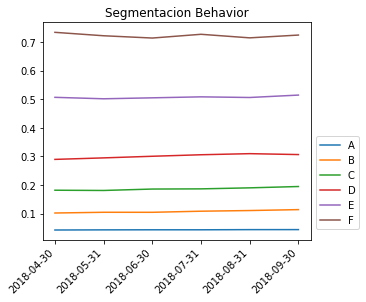

In [10]:
rev=comp[comp['flag_final']!=2]
rev=rev.groupby(['score','flag_final','dfecrep']).count()['ccodcli'].reset_index().pivot_table(values='ccodcli', index=['dfecrep','score'], \
columns=['flag_final'], aggfunc=np.sum).reset_index()
rev['total']=rev.iloc[:,2]+rev.iloc[:,3]
rev['pd']=rev.iloc[:,3]/rev['total']
rev=rev.reset_index()
rev=rev.pivot_table(values='pd',index=['dfecrep'],columns=['score'], aggfunc=np.sum).reset_index()
#rev=rev[rev['dfecrep']<='2019-10-31']
plt.plot(rev['dfecrep'],rev[['A','B','C','D','E','F']])
plt.title('Segmentacion Behavior')
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(rev[['A','B','C','D','E','F']],loc="upper left",bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
rev

In [11]:
comp['flag_final'].unique()

array([2, 0, 1], dtype=int64)

# Exportar

In [288]:
''' Funcion para escribir xlsx'''
from pandas import ExcelWriter
def save_xls(list_dfs, xls_path):
    with ExcelWriter(xls_path) as writer:
        for n, df in enumerate(list_dfs):
            df.to_excel(writer,'sheet%s' % n)
        writer.save()

In [289]:
#save_xls([card2,seg,results,ivs],'comportamental_rere.xlsx')

In [296]:
save_xls([seg],'seg2.xlsx')

In [323]:
comp.dfecrep.min()

'2018-04-30'

In [335]:
compf.head()

,ccalext,ccodcli,Z,nexpcli,betasvivienda,edad,nromesesatrasos8,mesesdesdeelmaximo,nroentidadesacreedoras,atrasomaximo6meses,...,natrmax,natrmax_flag,n_rcc,atraso12,atraso0,diasAtr12,flag_final,flag_ini,rango0,rango12
1,0,0360040398,-2.761,30,0.0,55,0,8.0,2,9.0,...,None,1,6.0,3,2,3,0,0,1-8,1-8
2,0,0130161268,-2.671,24,0.0,55,0,9.0,3,0.0,...,None,1,6.0,3,0,3,0,0,<0,1-8
3,0,0034408393,-3.367,35,0.0,55,0,11.0,2,2.0,...,None,1,6.0,1,0,1,0,0,<0,1-8
4,0,0110040102,-3.341,92,0.0,55,0,1.0,2,0.0,...,None,1,6.0,1,-1,1,0,0,<0,1-8
5,0,0190020883,-2.613,17,0.0,55,0,5.0,2,1.0,...,None,1,6.0,0,0,0,0,0,<0,<0


# Guardando informacion

In [4]:
import pickle

In [343]:
#pickle.dump(g, open('g_c.pkl','wb'))
pickle.dump(frames, open('frames_c.pkl','wb'))
pickle.dump(ivs, open('ivs_c.pkl','wb'))
pickle.dump(comp, open('comp_c.pkl','wb'))
pickle.dump(compf, open('compf_c.pkl','wb'))
pickle.dump(X_trainc, open('X_trainc_c.pkl','wb'))
pickle.dump(X_testc, open('X_testc_c.pkl','wb'))
pickle.dump(y_trainc, open('y_trainc_c.pkl','wb'))
pickle.dump(y_testc, open('y_testc_c.pkl','wb'))
pickle.dump(X_testf, open('X_testf_c.pkl','wb'))
pickle.dump(X_trainf, open('X_trainf_c.pkl','wb'))
pickle.dump(model, open('model_c.pkl','wb'))
pickle.dump(card2, open('card2_c.pkl','wb'))
pickle.dump(seg, open('seg_c.pkl','wb'))
pickle.dump(results, open('results_c.pkl','wb'))
#pickle.dump(seg2, open('seg2_c.pkl','wb'))
pickle.dump(m, open('m_c.pkl','wb'))
pickle.dump(rr, open('rr_c.pkl','wb'))

# Cargando Informacion

In [10]:
import gc
gc.collect()

852

In [1]:
import pickle

In [2]:
#frames=pickle.load(open('frames_c.pkl','rb'))
ivs=pickle.load(open('ivs_c.pkl','rb'))
comp=pickle.load(open('comp_c.pkl','rb'))
compf=pickle.load( open('compf_c.pkl','rb'))
X_trainc=pickle.load( open('X_trainc_c.pkl','rb'))
X_testc=pickle.load( open('X_testc_c.pkl','rb'))
y_trainc=pickle.load( open('y_trainc_c.pkl','rb'))
y_testc=pickle.load( open('y_testc_c.pkl','rb'))
X_testf=pickle.load( open('X_testf_c.pkl','rb'))
X_trainf=pickle.load( open('X_trainf_c.pkl','rb'))
model=pickle.load(open('model_c.pkl','rb'))
card2=pickle.load( open('card2_c.pkl','rb'))
seg=pickle.load(open('seg_c.pkl','rb'))
results=pickle.load(open('results_c.pkl','rb'))
#pickle.dump(seg2, open('seg2_c.pkl','rb'))
#m=pickle.load(open('m_c.pkl','rb'))
#rr=pickle.load( open('rr_c.pkl','rb'))

In [8]:
X_trainc.head()

,ccalext,ccodcli,Z,nexpcli,betasvivienda,edad,nromesesatrasos8,mesesdesdeelmaximo,nroentidadesacreedoras,atrasomaximo6meses,...,nroentidadesacreedoras_binned,atrasomaximo6meses_binned,indcomportamiento_binned,atr12meses_binned,PRE_1_binned,flag_binned,atraso12_binned,atraso0_binned,diasAtr12_binned,cconviv_binned
593888,0,0490111861,-2.551,8,0.0,57,0,5.0,2,0.0,...,0.029662,0.736922,0.205751,2.121421,0.285583,0.153179,1.488368,0.308199,inf,0.180999
171175,0,0034110098,-1.926,36,0.0,46,0,1.0,3,2.0,...,-0.473545,0.332210,0.205751,-inf,-0.333032,0.153179,-inf,-0.159864,-1.157354,0.180999
357691,0,0014313274,-4.017,112,0.209,46,0,5.0,1,2.0,...,0.805060,0.332210,0.205751,2.121421,1.926931,0.153179,1.488368,-0.159864,-1.157354,-0.142034
355962,0,0670147867,-2.316,8,0.209,55,0,5.0,2,0.0,...,0.029662,0.736922,0.205751,2.121421,-0.016832,0.153179,1.488368,0.308199,inf,-0.142034
140953,0,0250164548,-3.032,23,0.0,64,0,7.0,2,0.0,...,0.029662,0.736922,0.205751,2.121421,0.813610,0.153179,1.488368,0.308199,inf,0.180999


In [332]:
#import dill
#dill.dump_session('comportamental_final.db')

TypeError: no default __reduce__ due to non-trivial __cinit__

In [ ]:
#dill.load_session('notebook_env.db'

# Data para Experian

In [39]:
comp.columns

Index(['ccalext', 'ccodcli', 'Z', 'nexpcli', 'betasvivienda', 'edad',
       'nromesesatrasos8', 'mesesdesdeelmaximo', 'nroentidadesacreedoras',
       'atrasomaximo6meses', 'indcomportamiento', 'dfecrep', 'cconviv',
       'atr12meses', 'PRE_1', 'ccalcomp', 'flag', 'ccodsbs', 'natrmax',
       'natrmax_flag', 'n_rcc', 'atraso12', 'atraso0', 'diasAtr12',
       'flag_final', 'flag_ini', 'rango0', 'rango12', 'Z_binned',
       'nexpcli_binned', 'edad_binned', 'nromesesatrasos8_binned',
       'mesesdesdeelmaximo_binned', 'nroentidadesacreedoras_binned',
       'atrasomaximo6meses_binned', 'indcomportamiento_binned',
       'atr12meses_binned', 'PRE_1_binned', 'flag_binned', 'atraso12_binned',
       'atraso0_binned', 'diasAtr12_binned', 'cconviv_binned', 'puntaje',
       'bucket', 'pd', 'score', 'train', 'test'],
      dtype='object')

In [20]:
comp['train']=X_trainc['ccodcli']
comp['test']=X_testc['ccodcli']

In [31]:
import pandas as pd
comp['train']=comp['train'].apply(lambda x: 0 if pd.isnull(x) else 1)
comp['test']=comp['test'].apply(lambda x: 0 if pd.isnull(x) else 1)

In [43]:
comp['id']=1-comp['flag_final']

In [32]:
comp[['flag_final','train','test']].head(10)

,flag_final,train,test
0,2,0,0
1,0,1,0
2,0,1,0
3,0,0,1
4,0,1,0
5,0,1,0
6,0,1,0
7,2,0,0
8,2,0,0
9,0,1,0


Comprobación

In [61]:
experian = smf.logit(formula='id ~ nexpcli_binned + edad_binned + nromesesatrasos8_binned+ mesesdesdeelmaximo_binned+ nroentidadesacreedoras_binned+ atrasomaximo6meses_binned + cconviv_binned ', data= comp[(comp['train']==1) & (comp['flag_final'] !=2)] )
experian = experian.fit()
print(experian.summary())

Optimization terminated successfully.
         Current function value: 0.384029
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                     id   No. Observations:               338990
Model:                          Logit   Df Residuals:                   338982
Method:                           MLE   Df Model:                            7
Date:                Tue, 26 Nov 2019   Pseudo R-squ.:                  0.2034
Time:                        16:04:10   Log-Likelihood:            -1.3018e+05
converged:                       True   LL-Null:                   -1.6341e+05
                                        LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.4742      0.005    285.926      0.

In [87]:
experian=comp[['ccodcli','dfecrep', 'ccodsbs','nexpcli', 'edad',
       'nromesesatrasos8', 'mesesdesdeelmaximo', 'nroentidadesacreedoras',
       'atrasomaximo6meses',  'cconviv',
       'flag_final', 
       'nexpcli_binned', 'edad_binned', 'nromesesatrasos8_binned',
       'mesesdesdeelmaximo_binned', 'nroentidadesacreedoras_binned',
       'atrasomaximo6meses_binned', 'cconviv_binned',  'puntaje','score', 'train', 'test']]

In [88]:
experian['puntaje']=round(experian['puntaje'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [89]:
experian.to_csv('comportamental_envio.csv')

In [92]:
comp['cconviv'].unique()

array(['1', '2', '6', '3', '0', ' ', '5', '4'], dtype=object)